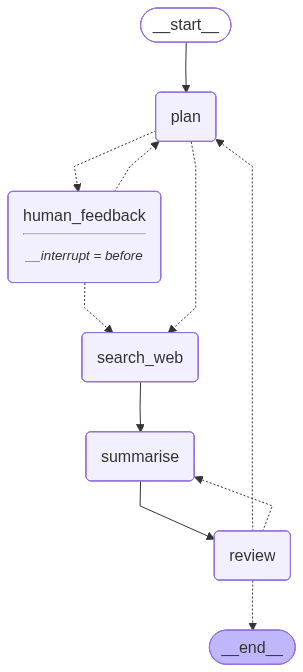

In [1]:
from pprint import pprint

from langchain_core.messages import HumanMessage

from nodes.question_nodes import plan, summarise, should_break_query, human_feedback, is_finished, should_skip_human_feedback
from nodes.search_nodes import search_web
from nodes.review_nodes import review

from state import WebSearchState
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


# Add nodes and edges
builder = StateGraph(state_schema=WebSearchState)
builder.add_node("plan", plan)
builder.add_node("search_web", search_web)
builder.add_node("summarise", summarise)
builder.add_node("human_feedback", human_feedback)
builder.add_node("review", review)

builder.add_edge(START, "plan")
builder.add_conditional_edges("plan", should_skip_human_feedback, ["human_feedback", "search_web"])
builder.add_conditional_edges("human_feedback", should_break_query, ["plan", "search_web"])

builder.add_edge("search_web", "summarise")
builder.add_edge("summarise", "review")
builder.add_conditional_edges("review", is_finished, [END, "plan", "summarise"])

# Compile
memory = MemorySaver()
graph = builder.compile(checkpointer=memory, interrupt_before=["human_feedback"])

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [2]:
# Step 1: Initial invoke - generates sub-questions and stops
thread = {"configurable": {"thread_id": "1"}}
for event in graph.stream(
    {"query": "What's the difference between LangSmith and LangGraph?"},
    thread, stream_mode="updates"
):
    print(event)

# Step 2: Check generated questions
state = graph.get_state(thread)
print("Generated questions:", state.values.get("questions"))

# Get user input
user_input = input("Tell me how you want to update the questions: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_feedback": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="updates"):
    print(event)

# Step 4: Check final results
final_state = graph.get_state(thread)
print("Summary:", final_state.values.get("summary"))


Creating sub-questions
{'plan': {'query': "What's the difference between LangSmith and LangGraph?", 'break_questions_iterations_count': 1, 'questions': ['What are the key features and functionalities of LangSmith?', 'What are the key features and functionalities of LangGraph?'], 'messages': [AIMessage(content="I'm now going to search for these topics:**1**. **What are the key features and functionalities of LangSmith?**\n**2**. **What are the key features and functionalities of LangGraph?**", additional_kwargs={}, response_metadata={}, id='1c071af1-e632-4054-8159-6e68bbf5d46a', tool_calls=[], invalid_tool_calls=[])]}}
{'__interrupt__': ()}
Generated questions: ['What are the key features and functionalities of LangSmith?', 'What are the key features and functionalities of LangGraph?']
Considering human feedback ...


KeyboardInterrupt: 

In [3]:
# Get user input
user_input = ""

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_feedback": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="updates"):
    try:
        event["messages"].pretty_print()
    except:
        pass

Current sub questions are:
1. What are the core features and functionalities of LangSmith?
2. What are the core features and functionalities of LangGraph?
3. How does LangChain differ from LangSmith and LangGraph in terms of features and functionalities?
Router decision: search_web
Router reasoning: The user is asking for a direct comparison between LangSmith and LangGraph. While sub-questions 1 and 2 cover their individual features, a detailed comparison requires additional information about their specific differences in functionality, use cases, and integration capabilities. Searching the web will provide up-to-date and comprehensive insights to answer this effectively.
Relevance check for 'What are the differences and functionalities of La...': True - The search result directly addresses the query by explaining LangSmith's core functionalities as a developer tool for building, debugging, and monitoring LLM applications, providing factual and relevant information.
Relevance check for

In [4]:
state = graph.get_state(thread)
print("Generated questions:", state.values.get("questions"))

Generated questions: ['What are the core features and functionalities of LangSmith?', 'What are the core features and functionalities of LangGraph?', 'How does LangChain differ from LangSmith and LangGraph in terms of features and functionalities?']


In [5]:
for key, value in state.values.items():
    print(f"{key}: {value}")
    print("------")

messages: [AIMessage(content='Breaking down the query into sub-questions:\n1. What are the core features and functionalities of LangSmith?\n2. What are the core features and functionalities of LangGraph?', additional_kwargs={}, response_metadata={}, id='7e5be505-a8c7-4ca6-903d-5165724e4add', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='Breaking down the query into sub-questions:\n1. What are the core features and functionalities of LangSmith?\n2. What are the core features and functionalities of LangGraph?\n3. How does LangChain differ from LangSmith and LangGraph in terms of features and functionalities?', additional_kwargs={}, response_metadata={}, id='50e9b376-86f0-4d2c-9d46-d94876c12b07', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='Searched for: **What are the core features and functionalities of LangSmith?** (Found 3 relevant results)', additional_kwargs={}, response_metadata={}, id='defedc4c-854d-4f89-a46c-aed7f77d0dd1', tool_calls=[], invalid_tool_call

In [6]:
state.values.get("summary").pretty_print()

================================== Ai Message ==================================

### Introduction  
LangSmith and LangGraph are both tools within the LangChain ecosystem, but they serve distinct purposes. LangSmith focuses on **observability, debugging, and monitoring** of LLM applications, while LangGraph is designed for **orchestrating complex, stateful workflows**. This answer clarifies their differences based on the provided context.

---

### Detailed Analysis  

#### **LangSmith: Observability and Debugging**  
LangSmith is a developer tool provided by LangChain, aimed at **building, debugging, and monitoring applications that utilize large language models (LLMs)** [1]. Its core functionalities include:  
1. **Tracing and Debugging**: It allows developers to trace requests, evaluate outputs, and debug workflows in real-time [2].  
2. **Evaluation Framework**: LangSmith provides tools to test prompts, measure performance, and conduct A/B testing for LLM outputs [2].  
3. **Integr